# Deep Learning Project - Bees Classifier  (Apis vs Bombus)

## In this project, I used a dataset of two kinds of bees: Apis and Bombus. The task is to clasify these types of bees. 

## I used Transfer Learning approach to train a pre-trained model with the available dataset. 

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

import shutil
import csv
import random

### The data is given as a set of numbered images with a csv file, which contains the class of bee against the number. 

### The follwing script copies the respective bee images to the respective folder: Apis and Bombus

In [2]:
mydict = {}

with open('data/train_labels.csv', 'r') as infile:
    reader = csv.reader(infile)
    with open('train_temp.csv', 'w') as outfile:
        writer = csv.writer(outfile)
        mydict = {rows[0]:rows[1] for rows in reader}

apis = 'data/apis/'
bombus = 'data/bombus/'

try:
    os.mkdir(apis)
    print('Directory apis created')
except OSError as error:
    print(error)
    
try:
    os.mkdir(bombus)
    print('Directory bombus created')
except OSError as error:
    print(error)
    
for key, value in mydict.items():
    path = 'data/images/train/' + key + '.jpg'
    if value == '1':
        shutil.copy2(path, bombus)
    elif value == '0':
        shutil.copy2(path, apis)
    else:
        pass
    
os.remove('train_temp.csv')

Directory apis created
Directory bombus created


### Further, I split the images from these folder to create training and validation sets (80:20) 

In [3]:
train_dir = 'data/train'
validation_dir = 'data/validation'
try:
    os.mkdir(train_dir)
except OSError as error:
    print(error)
try:
    os.mkdir(validation_dir)
except OSError as error:
    print(error)
    
train_apis_dir = os.path.join(train_dir, 'apis')
train_bombus_dir = os.path.join(train_dir, 'bombus')
try:
    os.mkdir(train_apis_dir)
except OSError as error:
    print(error)

try:
    os.mkdir(train_bombus_dir)
except OSError as error:
    print(error)
    
valid_apis_dir = os.path.join(validation_dir, 'apis')
valid_bombus_dir = os.path.join(validation_dir, 'bombus')
try:
    os.mkdir(valid_apis_dir)
except OSError as error:
    print(error)
    
try:
    os.mkdir(valid_bombus_dir)
except OSError as error:
    print(error)
    
apis_images = [im for im in os.listdir(apis)]
random.shuffle(apis_images)

bombus_images = [im for im in os.listdir(bombus)]
random.shuffle(bombus_images)

for image in apis_images[:int(len(apis_images) * 0.8)]:
    src = os.path.join(apis, image)
    shutil.move(src, train_apis_dir)

for image in apis_images[int(len(apis_images) * 0.8):]:
    src = os.path.join(apis, image)
    shutil.move(src, valid_apis_dir)
    
for image in bombus_images[:int(len(bombus_images) * 0.8)]:
    src = os.path.join(bombus, image)
    shutil.move(src, train_bombus_dir)

for image in bombus_images[int(len(bombus_images) * 0.8):]:
    src = os.path.join(bombus, image)
    shutil.move(src, valid_bombus_dir)
    
print('Apis Training: ', len(os.listdir(train_apis_dir)))
print('Bombus Training: ', len(os.listdir(train_bombus_dir)))
print('Apis Validation: ', len(os.listdir(valid_apis_dir)))
print('Bombus Validation: ', len(os.listdir(valid_bombus_dir)))

Apis Training:  661
Bombus Training:  2513
Apis Validation:  166
Bombus Validation:  629


### Creating a tf.data.dataset using image_datset_from_directory

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (200, 200)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 3174 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 795 files belonging to 2 classes.


### Displaying the first nine images and labels from the training set:

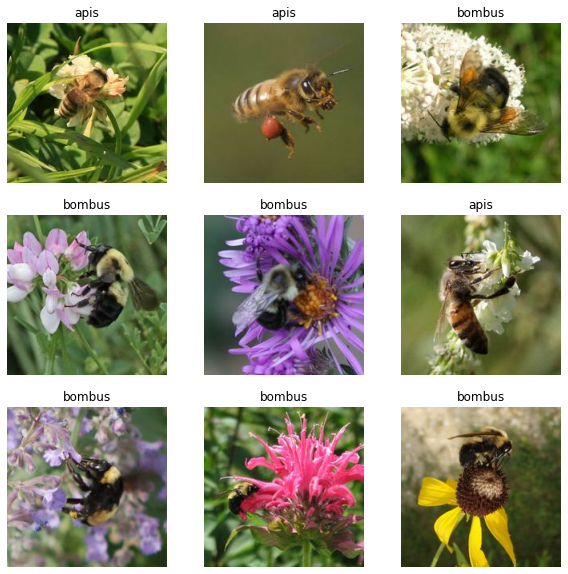

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Creating test dataset from validation set

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 20
Number of test batches: 5


### Configuring the dataset for performance (copied from tensorflow tutorials)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data augmentation and visulaization

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

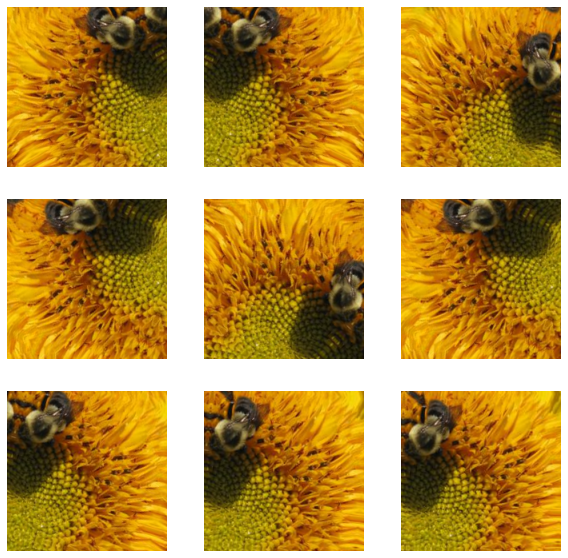

In [11]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Downloading a pre-trained model and rescaling pixel values

### I used ResNet50, which expects pixel values in the range [0,1]

In [12]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [13]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)

## Creating  the base model from the pre-trained convnets

### Excluding the last layer, whic is classifier, the rest of the model is kept. This acts as the base model for training and the deature extractor.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

### This feature extractor converts each 200x200x3 image into a 7x7x2048 block of features.

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


### From here on, we have two possibilities:

#### 1) To freeze the model, so that the weights doesn't get pdted during training
#### 2) To keep it unfrozen, so that the weights gets updated.

### I have approaced both ways and compared results.

### 1) First, I'll freeze the layers

In [16]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Adding a classification head

#### Now, to get predictions, a pooling layer is first added to convert the features into a single 2048-element vector per image

#### Furthe, a Dense layer is added to convert these features into a single pediction per image

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Building the model by adding all layers together

In [19]:
inputs = tf.keras.Input(shape=(200, 200, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compiling the model

#### Since, there are only two kinds of bees in the dataset, I used binary cross entropy

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 200, 200, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 200, 200, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

### Training the model

In [21]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 24s 1s/step - loss: 0.8909 - accuracy: 0.2705
initial loss: 0.88
initial accuracy: 0.29


In [22]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
100/100 [==============================] - 142s 1s/step - loss: 0.5653 - accuracy: 0.6909 - val_loss: 0.4853 - val_accuracy: 0.7732
Epoch 2/10
100/100 [==============================] - 142s 1s/step - loss: 0.4803 - accuracy: 0.7647 - val_loss: 0.4426 - val_accuracy: 0.7921
Epoch 3/10
100/100 [==============================] - 140s 1s/step - loss: 0.4335 - accuracy: 0.7864 - val_loss: 0.3890 - val_accuracy: 0.8283
Epoch 4/10
100/100 [==============================] - 140s 1s/step - loss: 0.4001 - accuracy: 0.8084 - val_loss: 0.3601 - val_accuracy: 0.8441
Epoch 5/10
100/100 [==============================] - 140s 1s/step - loss: 0.3665 - accuracy: 0.8229 - val_loss: 0.3593 - val_accuracy: 0.8472
Epoch 6/10
100/100 [==============================] - 165s 2s/step - loss: 0.3470 - accuracy: 0.8393 - val_loss: 0.3132 - val_accuracy: 0.8756
Epoch 7/10
100/100 [==============================] - 239s 2s/step - loss: 0.3270 - accuracy: 0.8535 - val_loss: 0.2954 - val_accuracy: 0.8835

### Visualizing the Learning curves

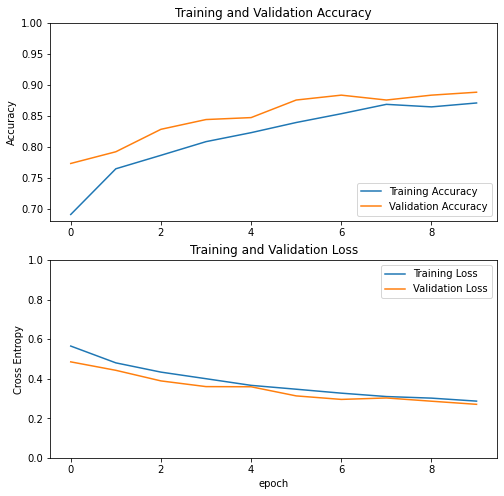

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Saving the model

In [24]:
export_path = "/home/aditya/Desktop/bees_models/without_finetune"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /home/aditya/Desktop/bees_models/without_finetune/assets


'/home/aditya/Desktop/bees_models/without_finetune'

### Evaluating model on test dataset

In [25]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 10s 2s/step - loss: 0.3202 - accuracy: 0.8750
Test accuracy : 0.875


## 2) Now, Unfreezing some layers of the model


### Here, I have kept some deep layers frozen and fine tuned the rest of the top layers

In [26]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  175


### Compiling the model

#### Since, the model is now much larger, I have reduce the learning rate to avoid overfitting

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 200, 200, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 200, 200, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

### Training the model

In [28]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
100/100 [==============================] - 467s 5s/step - loss: 0.2271 - accuracy: 0.8937 - val_loss: 0.1612 - val_accuracy: 0.9181
Epoch 11/20
100/100 [==============================] - 514s 5s/step - loss: 0.1574 - accuracy: 0.9309 - val_loss: 0.1283 - val_accuracy: 0.9496
Epoch 12/20
100/100 [==============================] - 533s 5s/step - loss: 0.1296 - accuracy: 0.9451 - val_loss: 0.1162 - val_accuracy: 0.9449
Epoch 13/20
100/100 [==============================] - 473s 5s/step - loss: 0.0946 - accuracy: 0.9617 - val_loss: 0.1403 - val_accuracy: 0.9354
Epoch 14/20
100/100 [==============================] - 277s 3s/step - loss: 0.0895 - accuracy: 0.9683 - val_loss: 0.1550 - val_accuracy: 0.9496
Epoch 15/20
100/100 [==============================] - 278s 3s/step - loss: 0.0670 - accuracy: 0.9796 - val_loss: 0.1172 - val_accuracy: 0.9559
Epoch 16/20
100/100 [==============================] - 278s 3s/step - loss: 0.0634 - accuracy: 0.9723 - val_loss: 0.1542 - val_accuracy:

### Visualizing the curves

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

TypeError: unsupported operand type(s) for +=: 'float' and 'list'

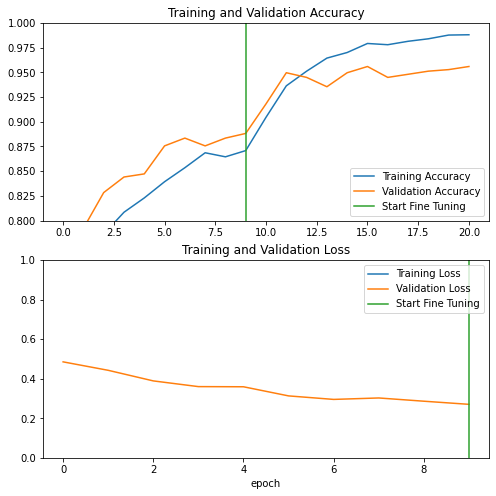

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Saving the fine tuned model

In [31]:
export_path = "/home/aditya/Desktop/bees_models/with_finetune"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /home/aditya/Desktop/bees_models/with_finetune/assets


'/home/aditya/Desktop/bees_models/with_finetune'

### Evaluating the new model on test dataset

In [32]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 6s 1s/step - loss: 0.1317 - accuracy: 0.9500
Test accuracy : 0.949999988079071


## 3) Unfreezing all layers of the model

In [33]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


### Compiling the model

In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/100),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 200, 200, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 200, 200, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

### Training the model

In [35]:
fine_tune_unfrozen_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs + fine_tune_unfrozen_epochs

history_fine_unfrozen = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40
100/100 [==============================] - 528s 5s/step - loss: 0.0226 - accuracy: 0.9924 - val_loss: 0.1746 - val_accuracy: 0.9575
Epoch 21/40
100/100 [==============================] - 516s 5s/step - loss: 0.0137 - accuracy: 0.9954 - val_loss: 0.1586 - val_accuracy: 0.9591
Epoch 22/40
100/100 [==============================] - 516s 5s/step - loss: 0.0195 - accuracy: 0.9927 - val_loss: 0.1719 - val_accuracy: 0.9591
Epoch 23/40
100/100 [==============================] - 516s 5s/step - loss: 0.0150 - accuracy: 0.9933 - val_loss: 0.1372 - val_accuracy: 0.9638
Epoch 24/40
100/100 [==============================] - 518s 5s/step - loss: 0.0208 - accuracy: 0.9949 - val_loss: 0.1639 - val_accuracy: 0.9606
Epoch 25/40
100/100 [==============================] - 516s 5s/step - loss: 0.0144 - accuracy: 0.9955 - val_loss: 0.1827 - val_accuracy: 0.9591
Epoch 26/40
100/100 [==============================] - 786s 8s/step - loss: 0.0154 - accuracy: 0.9932 - val_loss: 0.1898 - val_accuracy:

### Visualizing the curves

In [36]:
acc += history_fine_unfrozen.history['accuracy']
val_acc += history_fine_unfrozen.history['val_accuracy']

loss += history_fine_unfrozen.history['loss']
val_loss += history_fine_unfrozen.history['val_loss']

TypeError: unsupported operand type(s) for +=: 'float' and 'list'

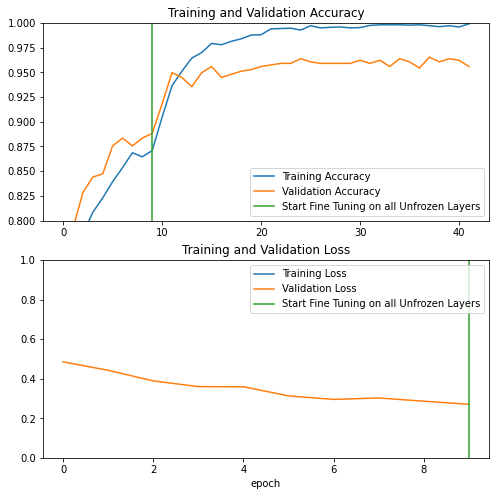

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning on all Unfrozen Layers')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning on all Unfrozen Layers')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Saving the fine tuned model

In [ ]:
export_path = "/home/aditya/Desktop/bees_models/with_finetune_unfrozen"
model.save(export_path)

export_path

### Evaluating the new model on test dataset

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)